In [13]:
pwd

'/home/uniq/Documents/Deep Learning/VANILLA GAN'

In [14]:
#import packages
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import DataLoader

from torchvision.datasets import FashionMNIST
from torchvision import transforms

from tqdm import tqdm

from matplotlib import pyplot as plt


In [15]:
#Hyper parameters
lr = 0.001
batch_size = 64
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset Preparations

In [16]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Ensures input range is [-1, 1]
])


In [17]:
# fashion_datasets = FashionMNIST('./fashion_data', train=True, download=True)
fashion_datasets = FashionMNIST('./fashion_data', train=True, download=True, transform=image_transforms)


100%|██████████| 26.4M/26.4M [00:04<00:00, 5.73MB/s]


Extracting ./fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 152kB/s]


Extracting ./fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.68MB/s]


Extracting ./fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.39MB/s]

Extracting ./fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw



In [18]:
fashion_dataloader = DataLoader(fashion_datasets, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)


In [19]:
next(iter(fashion_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

# Model Building

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)
            

In [21]:
discriminator = Discriminator()
discriminator(torch.rand(10,784)).shape

torch.Size([10, 1])

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # random noise 100 length
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh() #-1 to 1
        )
    def forward(self, x):
        return self.model(x)

In [23]:
generator = Generator()
generator(torch.randn(10,100)).shape

torch.Size([10, 784])

In [24]:
def noise(batch_size,device):
    return torch.randn(batch_size,100).to(device=device)

noise(64, 'cuda').shape

torch.Size([64, 100])

In [25]:

def visualize_samples(generator, device):
    # Generate noise and create fake samples
    samples = generator(noise(16, device)).view(-1, 28, 28).cpu().detach()

    # Create a grid for visualization
    grid = torch.cat([torch.cat([samples[i + j * 4] for i in range(4)], dim=1) for j in range(4)], dim=0)
    
    # Plot the grid
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="gray")
    plt.axis("off")
    plt.show()


## Model Configurations

In [26]:
discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)
criteria = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001) # gradient is calculated for all the parameters but it is updated only for the discriminator
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [27]:
def train_discriminator(discriminator, criteria, d_optimizer, real_image, fake_image, device):
    discriminator.train()
    d_optimizer.zero_grad()
    
    # Smooth labels for real and fake samples
    real_labels = torch.full((len(real_image), 1), 0.9, device=device)  # Smoothed real labels
    fake_labels = torch.full((len(fake_image), 1), 0.1, device=device)  # Smoothed fake labels

    # Forward pass for real images
    real_output = discriminator(real_image)
    real_loss = criteria(real_output, real_labels)

    # Forward pass for fake images
    fake_output = discriminator(fake_image)
    fake_loss = criteria(fake_output, fake_labels)

    # Combine losses
    total_loss = real_loss + fake_loss

    # Backpropagate and update discriminator weights
    total_loss.backward()
    d_optimizer.step()
    
    return total_loss


In [28]:
torch.zeros(64,1).shape

torch.Size([64, 1])

In [29]:
def train_generator(discriminator, criteria, g_optimizer, fake_image, device):
    g_optimizer.zero_grad()
    output = discriminator(fake_image)
    loss = criteria(output, torch.ones(len(output),1).to(device=device))  # generator should generate image that should be classified as 1 so torch.ones 
    loss.backward()

    g_optimizer.step()
    return loss

Train 1 of 100: 100%|██████████| 938/938 [00:08<00:00, 106.83it/s]


Epoch 1/100
Generator Loss: 2066.7957, Discriminator Loss: 749.2951


Train 2 of 100: 100%|██████████| 938/938 [00:09<00:00, 99.64it/s] 


Epoch 2/100
Generator Loss: 2375.0642, Discriminator Loss: 764.0722


Train 3 of 100: 100%|██████████| 938/938 [00:08<00:00, 109.34it/s]


Epoch 3/100
Generator Loss: 1918.4574, Discriminator Loss: 827.6089


Train 4 of 100: 100%|██████████| 938/938 [00:08<00:00, 109.92it/s]


Epoch 4/100
Generator Loss: 1734.3264, Discriminator Loss: 882.3795


Train 5 of 100: 100%|██████████| 938/938 [00:08<00:00, 109.29it/s]


Epoch 5/100
Generator Loss: 1505.4989, Discriminator Loss: 947.5882


Train 6 of 100: 100%|██████████| 938/938 [00:07<00:00, 118.88it/s]


Epoch 6/100
Generator Loss: 1340.7169, Discriminator Loss: 996.2707


Train 7 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.35it/s]


Epoch 7/100
Generator Loss: 1240.9136, Discriminator Loss: 1029.1981


Train 8 of 100: 100%|██████████| 938/938 [00:08<00:00, 110.26it/s]


Epoch 8/100
Generator Loss: 1231.0280, Discriminator Loss: 1037.6855


Train 9 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.10it/s]


Epoch 9/100
Generator Loss: 1175.5355, Discriminator Loss: 1055.1778


Train 10 of 100: 100%|██████████| 938/938 [00:08<00:00, 106.23it/s]


Epoch 10/100
Generator Loss: 1115.5774, Discriminator Loss: 1079.4578


Train 11 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.74it/s]


Epoch 11/100
Generator Loss: 1109.2372, Discriminator Loss: 1088.3441


Train 12 of 100: 100%|██████████| 938/938 [00:08<00:00, 107.37it/s]


Epoch 12/100
Generator Loss: 1101.4881, Discriminator Loss: 1086.6935


Train 13 of 100: 100%|██████████| 938/938 [00:07<00:00, 117.85it/s]


Epoch 13/100
Generator Loss: 1051.2243, Discriminator Loss: 1103.6771


Train 14 of 100: 100%|██████████| 938/938 [00:08<00:00, 109.32it/s]


Epoch 14/100
Generator Loss: 1045.1074, Discriminator Loss: 1111.4424


Train 15 of 100: 100%|██████████| 938/938 [00:07<00:00, 117.47it/s]


Epoch 15/100
Generator Loss: 1032.8619, Discriminator Loss: 1114.3092


Train 16 of 100: 100%|██████████| 938/938 [00:07<00:00, 119.82it/s]


Epoch 16/100
Generator Loss: 1024.3154, Discriminator Loss: 1116.2579


Train 17 of 100: 100%|██████████| 938/938 [00:07<00:00, 120.17it/s]


Epoch 17/100
Generator Loss: 1060.3074, Discriminator Loss: 1101.7380


Train 18 of 100: 100%|██████████| 938/938 [00:07<00:00, 117.95it/s]


Epoch 18/100
Generator Loss: 1019.4272, Discriminator Loss: 1115.7260


Train 19 of 100: 100%|██████████| 938/938 [00:07<00:00, 119.90it/s]


Epoch 19/100
Generator Loss: 1059.9070, Discriminator Loss: 1102.3782


Train 20 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.56it/s]


Epoch 20/100
Generator Loss: 993.6672, Discriminator Loss: 1127.9989


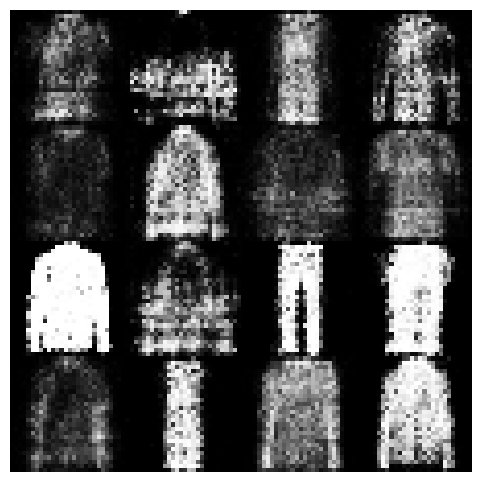

Train 21 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.16it/s]


Epoch 21/100
Generator Loss: 985.8182, Discriminator Loss: 1135.1604


Train 22 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.84it/s]


Epoch 22/100
Generator Loss: 997.4449, Discriminator Loss: 1129.7901


Train 23 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.70it/s]


Epoch 23/100
Generator Loss: 977.8904, Discriminator Loss: 1130.0702


Train 24 of 100: 100%|██████████| 938/938 [00:08<00:00, 105.03it/s]


Epoch 24/100
Generator Loss: 947.5325, Discriminator Loss: 1154.5015


Train 25 of 100: 100%|██████████| 938/938 [00:10<00:00, 89.04it/s] 


Epoch 25/100
Generator Loss: 937.5618, Discriminator Loss: 1153.0275


Train 26 of 100: 100%|██████████| 938/938 [00:10<00:00, 90.99it/s]


Epoch 26/100
Generator Loss: 943.0228, Discriminator Loss: 1149.2338


Train 27 of 100: 100%|██████████| 938/938 [00:08<00:00, 105.93it/s]


Epoch 27/100
Generator Loss: 922.8700, Discriminator Loss: 1163.8884


Train 28 of 100: 100%|██████████| 938/938 [00:08<00:00, 107.05it/s]


Epoch 28/100
Generator Loss: 919.6123, Discriminator Loss: 1157.3453


Train 29 of 100: 100%|██████████| 938/938 [00:08<00:00, 106.14it/s]


Epoch 29/100
Generator Loss: 923.0421, Discriminator Loss: 1161.1407


Train 30 of 100: 100%|██████████| 938/938 [00:08<00:00, 111.67it/s]


Epoch 30/100
Generator Loss: 906.5421, Discriminator Loss: 1169.2941


Train 31 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.78it/s]


Epoch 31/100
Generator Loss: 924.2561, Discriminator Loss: 1161.0445


Train 32 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.68it/s]


Epoch 32/100
Generator Loss: 897.6049, Discriminator Loss: 1173.8122


Train 33 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.06it/s]


Epoch 33/100
Generator Loss: 908.9128, Discriminator Loss: 1167.8676


Train 34 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.49it/s]


Epoch 34/100
Generator Loss: 909.2862, Discriminator Loss: 1166.7357


Train 35 of 100: 100%|██████████| 938/938 [00:07<00:00, 117.69it/s]


Epoch 35/100
Generator Loss: 871.2869, Discriminator Loss: 1185.0320


Train 36 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.89it/s]


Epoch 36/100
Generator Loss: 906.2884, Discriminator Loss: 1170.4218


Train 37 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.26it/s]


Epoch 37/100
Generator Loss: 901.6572, Discriminator Loss: 1170.3370


Train 38 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.51it/s]


Epoch 38/100
Generator Loss: 892.9034, Discriminator Loss: 1171.6144


Train 39 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.56it/s]


Epoch 39/100
Generator Loss: 879.8427, Discriminator Loss: 1181.7473


Train 40 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.31it/s]


Epoch 40/100
Generator Loss: 866.7049, Discriminator Loss: 1190.1721


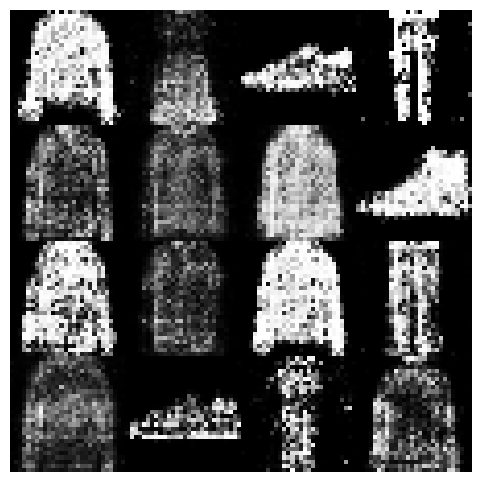

Train 41 of 100: 100%|██████████| 938/938 [00:08<00:00, 109.10it/s]


Epoch 41/100
Generator Loss: 883.8603, Discriminator Loss: 1175.6331


Train 42 of 100: 100%|██████████| 938/938 [00:08<00:00, 108.94it/s]


Epoch 42/100
Generator Loss: 854.1237, Discriminator Loss: 1195.4464


Train 43 of 100: 100%|██████████| 938/938 [00:08<00:00, 110.94it/s]


Epoch 43/100
Generator Loss: 864.9780, Discriminator Loss: 1188.7694


Train 44 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.76it/s]


Epoch 44/100
Generator Loss: 852.0464, Discriminator Loss: 1192.0472


Train 45 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.05it/s]


Epoch 45/100
Generator Loss: 860.2783, Discriminator Loss: 1194.0100


Train 46 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.75it/s]


Epoch 46/100
Generator Loss: 853.6535, Discriminator Loss: 1188.6388


Train 47 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.56it/s]


Epoch 47/100
Generator Loss: 863.4099, Discriminator Loss: 1185.9261


Train 48 of 100: 100%|██████████| 938/938 [00:08<00:00, 116.47it/s]


Epoch 48/100
Generator Loss: 833.6393, Discriminator Loss: 1203.4235


Train 49 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.61it/s]


Epoch 49/100
Generator Loss: 846.4866, Discriminator Loss: 1199.6305


Train 50 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.92it/s]


Epoch 50/100
Generator Loss: 835.0465, Discriminator Loss: 1203.2668


Train 51 of 100: 100%|██████████| 938/938 [00:08<00:00, 116.07it/s]


Epoch 51/100
Generator Loss: 848.3043, Discriminator Loss: 1195.9739


Train 52 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.09it/s]


Epoch 52/100
Generator Loss: 833.2935, Discriminator Loss: 1208.3665


Train 53 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.74it/s]


Epoch 53/100
Generator Loss: 817.2065, Discriminator Loss: 1224.5950


Train 54 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.37it/s]


Epoch 54/100
Generator Loss: 832.4190, Discriminator Loss: 1210.3970


Train 55 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.51it/s]


Epoch 55/100
Generator Loss: 851.6405, Discriminator Loss: 1190.5291


Train 56 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.31it/s]


Epoch 56/100
Generator Loss: 856.5150, Discriminator Loss: 1191.7599


Train 57 of 100: 100%|██████████| 938/938 [00:08<00:00, 116.58it/s]


Epoch 57/100
Generator Loss: 852.3766, Discriminator Loss: 1193.1968


Train 58 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.69it/s]


Epoch 58/100
Generator Loss: 825.3828, Discriminator Loss: 1210.0760


Train 59 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.12it/s]


Epoch 59/100
Generator Loss: 828.8109, Discriminator Loss: 1213.0889


Train 60 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.68it/s]


Epoch 60/100
Generator Loss: 818.6138, Discriminator Loss: 1215.7535


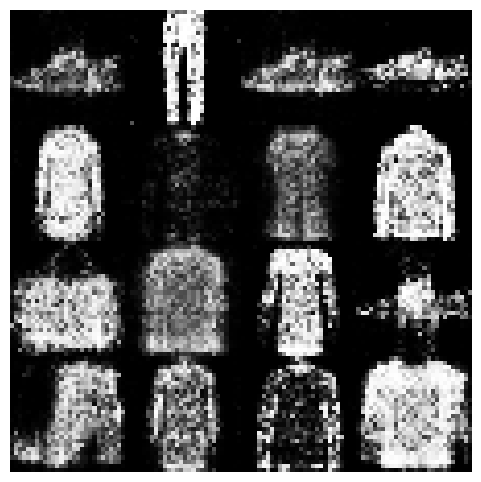

Train 61 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.18it/s]


Epoch 61/100
Generator Loss: 831.6265, Discriminator Loss: 1208.9265


Train 62 of 100: 100%|██████████| 938/938 [00:08<00:00, 116.00it/s]


Epoch 62/100
Generator Loss: 832.5264, Discriminator Loss: 1203.8707


Train 63 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.63it/s]


Epoch 63/100
Generator Loss: 830.1278, Discriminator Loss: 1213.5933


Train 64 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.48it/s]


Epoch 64/100
Generator Loss: 830.7460, Discriminator Loss: 1212.5893


Train 65 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.39it/s]


Epoch 65/100
Generator Loss: 826.7474, Discriminator Loss: 1208.8104


Train 66 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.77it/s]


Epoch 66/100
Generator Loss: 806.0515, Discriminator Loss: 1216.4858


Train 67 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.00it/s]


Epoch 67/100
Generator Loss: 806.6351, Discriminator Loss: 1225.9819


Train 68 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.98it/s]


Epoch 68/100
Generator Loss: 814.8191, Discriminator Loss: 1217.2757


Train 69 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.37it/s]


Epoch 69/100
Generator Loss: 796.5704, Discriminator Loss: 1224.3330


Train 70 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.48it/s]


Epoch 70/100
Generator Loss: 812.4983, Discriminator Loss: 1216.7007


Train 71 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.07it/s]


Epoch 71/100
Generator Loss: 802.2398, Discriminator Loss: 1226.0345


Train 72 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.83it/s]


Epoch 72/100
Generator Loss: 810.4255, Discriminator Loss: 1216.0351


Train 73 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.07it/s]


Epoch 73/100
Generator Loss: 817.7676, Discriminator Loss: 1223.0148


Train 74 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.85it/s]


Epoch 74/100
Generator Loss: 803.4832, Discriminator Loss: 1220.7067


Train 75 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.80it/s]


Epoch 75/100
Generator Loss: 802.2845, Discriminator Loss: 1225.6885


Train 76 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.83it/s]


Epoch 76/100
Generator Loss: 793.5460, Discriminator Loss: 1228.6132


Train 77 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.40it/s]


Epoch 77/100
Generator Loss: 790.6249, Discriminator Loss: 1228.5662


Train 78 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.89it/s]


Epoch 78/100
Generator Loss: 785.4525, Discriminator Loss: 1232.3438


Train 79 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.65it/s]


Epoch 79/100
Generator Loss: 793.8576, Discriminator Loss: 1225.1706


Train 80 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.76it/s]

Epoch 80/100
Generator Loss: 788.2511, Discriminator Loss: 1237.2706


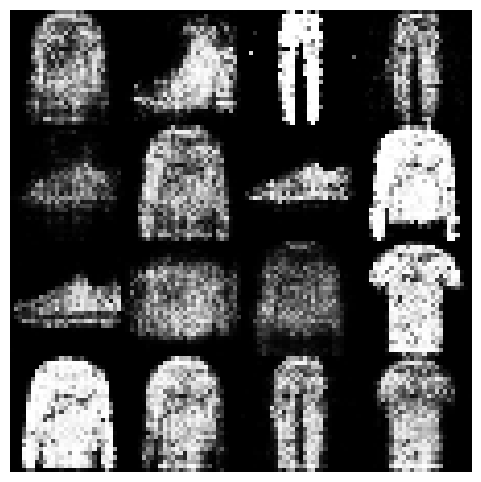

Train 81 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.68it/s]


Epoch 81/100
Generator Loss: 795.3878, Discriminator Loss: 1226.4486


Train 82 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.51it/s]


Epoch 82/100
Generator Loss: 777.0908, Discriminator Loss: 1236.6093


Train 83 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.67it/s]


Epoch 83/100
Generator Loss: 795.3963, Discriminator Loss: 1236.8334


Train 84 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.38it/s]


Epoch 84/100
Generator Loss: 775.8392, Discriminator Loss: 1237.0986


Train 85 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.81it/s]


Epoch 85/100
Generator Loss: 787.3777, Discriminator Loss: 1236.2160


Train 86 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.38it/s]


Epoch 86/100
Generator Loss: 772.0441, Discriminator Loss: 1237.1473


Train 87 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.71it/s]


Epoch 87/100
Generator Loss: 766.5114, Discriminator Loss: 1248.3774


Train 88 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.70it/s]


Epoch 88/100
Generator Loss: 768.1308, Discriminator Loss: 1240.7517


Train 89 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.25it/s]


Epoch 89/100
Generator Loss: 756.6598, Discriminator Loss: 1249.9480


Train 90 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.55it/s]


Epoch 90/100
Generator Loss: 783.6721, Discriminator Loss: 1247.0430


Train 91 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.98it/s]


Epoch 91/100
Generator Loss: 791.8669, Discriminator Loss: 1230.2616


Train 92 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.56it/s]


Epoch 92/100
Generator Loss: 770.9252, Discriminator Loss: 1239.3543


Train 93 of 100: 100%|██████████| 938/938 [00:08<00:00, 112.38it/s]


Epoch 93/100
Generator Loss: 755.8295, Discriminator Loss: 1248.8146


Train 94 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.81it/s]


Epoch 94/100
Generator Loss: 762.9917, Discriminator Loss: 1249.1589


Train 95 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.43it/s]


Epoch 95/100
Generator Loss: 750.0065, Discriminator Loss: 1252.1867


Train 96 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.14it/s]


Epoch 96/100
Generator Loss: 747.1743, Discriminator Loss: 1255.0104


Train 97 of 100: 100%|██████████| 938/938 [00:08<00:00, 115.40it/s]


Epoch 97/100
Generator Loss: 756.3466, Discriminator Loss: 1251.9283


Train 98 of 100: 100%|██████████| 938/938 [00:08<00:00, 111.61it/s]


Epoch 98/100
Generator Loss: 769.4097, Discriminator Loss: 1251.5346


Train 99 of 100: 100%|██████████| 938/938 [00:08<00:00, 114.53it/s]


Epoch 99/100
Generator Loss: 766.7525, Discriminator Loss: 1248.0474


Train 100 of 100: 100%|██████████| 938/938 [00:08<00:00, 113.65it/s]

Epoch 100/100
Generator Loss: 760.4903, Discriminator Loss: 1246.9873


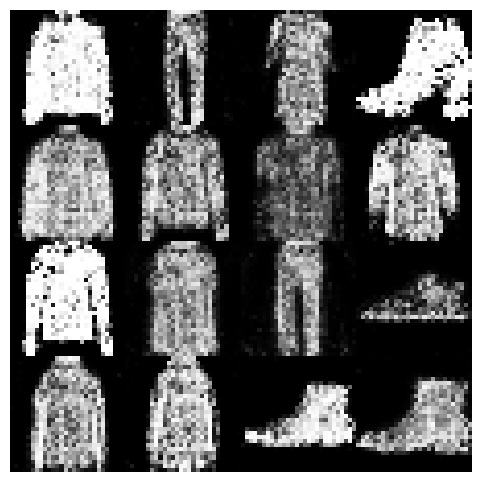

In [30]:
total_gen_loss, total_disc_loss = [], []

# Loop over epochs
for epoch in range(1, num_epochs + 1):
    epoch_gen_loss = 0
    epoch_disc_loss = 0

    # Loop over batches
    for images, _ in tqdm(fashion_dataloader, desc=f'Train {epoch} of {num_epochs}'):
        # Prepare real and fake images
        real_image = images.view(len(images), -1).to(device=device)
        fake_image = generator(noise(len(images), device=device))

        # Train the discriminator
        disc_loss = train_discriminator(discriminator, criteria, d_optimizer, real_image, fake_image, device)

        # Generate new fake images
        fake_image = generator(noise(len(images), device=device))

        # Train the generator
        gen_loss = train_generator(discriminator, criteria, g_optimizer, fake_image, device)

        # Accumulate losses for the epoch
        epoch_gen_loss += gen_loss.item()
        epoch_disc_loss += disc_loss.item()

    # Print epoch losses
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Generator Loss: {epoch_gen_loss:.4f}, Discriminator Loss: {epoch_disc_loss:.4f}")

    # Visualize generated samples
    if epoch %20  == 0:  # Visualize every epoch
        visualize_samples(generator, device)

    # Store losses for later visualization
    total_gen_loss.append(epoch_gen_loss)
    total_disc_loss.append(epoch_disc_loss)


In [31]:
# Save generator and discriminator models
torch.save(generator.state_dict(), 'fashion_generator.pth')
torch.save(discriminator.state_dict(), 'fashion_discriminator.pth')

In [32]:
generator.load_state_dict(torch.load('fashion_generator.pth'))
generator.eval()

/tmp/ipykernel_30100/687958849.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('fashion_generator.pth'))


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [33]:
z = torch.randn(1, 100).to(device)  # Batch size of 1, noise dim 100


In [34]:
with torch.no_grad():
    generated_image = generator(z).view(-1, 28, 28).cpu()  # Reshape to (1, 28, 28)


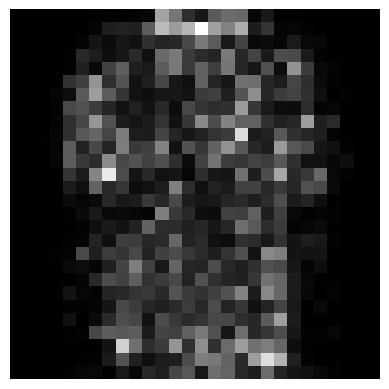

In [35]:
# Visualize the image
plt.imshow(generated_image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()